In [2]:
import os
import random
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import itertools


%env CUDA_VISIBLE_DEVICES=3
import torch
torch.no_grad()
print("cuda available: " + str(torch.cuda.is_available()))

#import cuml
from torchvision.utils import save_image, make_grid

from draw import draw

env: CUDA_VISIBLE_DEVICES=3
cuda available: True
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)
plt.rcParams.update({'font.size': 15})

## Set directories
1. summary file path: summary_name
2. path to save images: save_dir

In [9]:
save_dir = 'images'
experiment_name = 'syn_props'
summary_name = os.path.join('/home/rpeyser/GitHub/scSet/checkpoints/', experiment_name, 'summary.pth')

imgdir = os.path.join(save_dir, experiment_name)
imgdir_gt = os.path.join(imgdir, 'gt')
imgdir_recon = os.path.join(imgdir, 'recon')
imgdir_gen = os.path.join(imgdir, 'gen')

os.makedirs(save_dir, exist_ok=True)
os.makedirs(imgdir_gt, exist_ok=True)
os.makedirs(imgdir_recon, exist_ok=True)
os.makedirs(imgdir_gen, exist_ok=True)

In [10]:
summary_name

'/home/rpeyser/GitHub/scSet/checkpoints/syn_props/summary.pth'

### From summary, recon_set are the reconstructed outputs of the VAE, which is shape (n val samples, max cells per sample, n PCs). 
### Then use recon_mask to get true cells (not padding) per patient. 1 means pad, 0 means true cell.
### enc_hiddens, enc_latents, enc_att can be used to probe the hiden layers of the encoder
### pid lists the (batched) val set pids

In [11]:
summary = torch.load(summary_name)
for k, v in summary.items():
    try:
        print(f"{k}: {v.shape}")
    except AttributeError:
        print(f"{k}: {len(v)}")

smp_set: torch.Size([100, 700, 20])
smp_mask: torch.Size([100, 700])
smp_att: 5
priors: 6
recon_set: torch.Size([100, 700, 20])
recon_mask: torch.Size([100, 700])
posteriors: 6
dec_att: 5
enc_att: 5
enc_hiddens: 13
init_set: torch.Size([100, 700, 64])
dec_hiddens: 13
dec_latents: 13
gt_set: torch.Size([100, 504, 20])
gt_mask: torch.Size([100, 504])
mean: torch.Size([13])
std: torch.Size([13])
sid: 13
mid: 13
pid: 13
cardinality: 13


## Select the samples to visualize
- parse the samples by index.

In [ ]:
recon_targets = list(range(len(summary['gt_mask'])))[:]
gen_targets = list(range(len(summary['smp_mask'])))[:]

len_att = len(summary['dec_att'])
gt = summary['gt_set'][recon_targets]
gt_mask = summary['gt_mask'][recon_targets]

recon = summary['recon_set'][recon_targets]
recon_mask = summary['recon_mask'][recon_targets]

dec_att = [summary['dec_att'][l][:, :, recon_targets] for l in range(len_att)]
enc_att = [summary['enc_att'][l][:, :, recon_targets] for l in range(len_att)]

gen = summary['smp_set'][gen_targets]
gen_mask = summary['smp_mask'][gen_targets]
gen_att = [summary['smp_att'][l][:, :, gen_targets] for l in range(len_att)]

# Collate data across all samples. run UMAP, and viz

inputs were of size 350 cells each; it reconstructed (and generated) samples of 700 cells each
I thought that reconstruction should be set to have the same cardinality as gt?

In [86]:
print(gt.shape)
print(recon.shape)

torch.Size([100, 504, 20])
torch.Size([100, 700, 20])


In [18]:
gt_adata = sc.read_h5ad("/localdata/rna_rep_learning/scset/synthetic_props_exp/props_exp_adata.h5ad")


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
recon_adata = sc.AnnData(np.zeros([recon.reshape(-1,20)[(~recon_mask).reshape(-1),:].shape[0], len(gt_adata.var)])) #only take unmasked outputs!!!

In [ ]:
recon_adata.varm['PCs'] = gt_adata.varm['PCs']

In [ ]:
recon_adata.obsm['X_pca'] = recon.reshape(-1,20)[(~recon_mask).reshape(-1),:].numpy() #only take unmasked outputs!!

In [ ]:
recon_adata.var = gt_adata.var[['highly_variable','means','dispersions','mean','std']].rename(columns={'highly_variable':'highly_variable_orig', 'means':'means_orig', 'dispersions':'dispersions_orig', 'mean':'mean_orig', 'std':'std_orig'})



In [ ]:
## add info to recon_adata.obs

#add patient is
recon_pids = list(itertools.chain.from_iterable(summary['pid']))
recon_adata.obs['patient'] = np.repeat(recon_pids, (~recon_mask).sum(axis=1))

In [ ]:
#add patients groups 
recon_adata.obs = recon_adata.obs.merge(gt_adata.obs[['patient', 'setting']].drop_duplicates(), on="patient", how="left")

recon_adata.obs.index = recon_adata.obs.patient

#### calculate neighbors & UMAP for reconstructed cells

In [ ]:
sc.pp.neighbors(recon_adata, n_neighbors=30, n_pcs=20)

In [ ]:
sc.tl.umap(recon_adata)

In [ ]:
sc.pl.umap(recon_adata, color='setting')

In [ ]:
sc.pl.umap(recon_adata, color='patient')

In [ ]:
#add PCs to obs in order to color by them
recon_adata.obs = pd.concat([recon_adata.obs, pd.DataFrame(recon_adata.obsm['X_pca'], index=recon_adata.obs.index, columns=["PC"+str(i) for i in range(1,recon_adata.obsm['X_pca'].shape[1]+1)])], axis=1)

In [ ]:
sc.pl.umap(recon_adata, color=["PC"+str(i) for i in range(1,11)])

#### calculate gene expression based on predicted PCs for reconstructed data (as a baseline, check how different PC-reconstructed gene expression and true gene expression is for gt data)

In [ ]:
recon_adata.X = np.matmul(recon_adata.obsm['X_pca'], recon_adata.varm['PCs'][:,:20].transpose())

In [ ]:
sc.pl.umap(recon_adata, color=['CD14','CD33','CD8A','CD4','IL7R','SDC1','S100A9','CD19'], ncols=3)

# Write the reconstructed adata to file

In [71]:
recon_adata.write_h5ad("/localdata/rna_rep_learning/scset/synthetic_props_exp/props_valset_recon.h5ad")

In [79]:
# write just the obs matrix
recon_adata.obs.to_csv("/localdata/rna_rep_learning/scset/synthetic_props_exp/props_valset_obs.csv")

In [7]:
recon_adata = sc.read_h5ad("/localdata/rna_rep_learning/scset/synthetic_props_exp/props_valset_recon.h5ad")

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Visualize pseudobulk (sum all counts per gene per patient and renormalize)

In [26]:
pseudobulk_counts = pd.DataFrame(gt_adata.layers['counts'], index=gt_adata.obs.patient, columns=gt_adata.var.index).reset_index().groupby("patient").sum()

In [35]:
pseudobulk_lognorm = np.log1p(np.divide(pseudobulk_counts.T, pseudobulk_counts.sum(axis=1)))

In [47]:
# top 100 variable genes
gene_stds = pseudobulk_lognorm.std(axis=1)
topvargenes = gene_stds.sort_values()[-100:].index

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


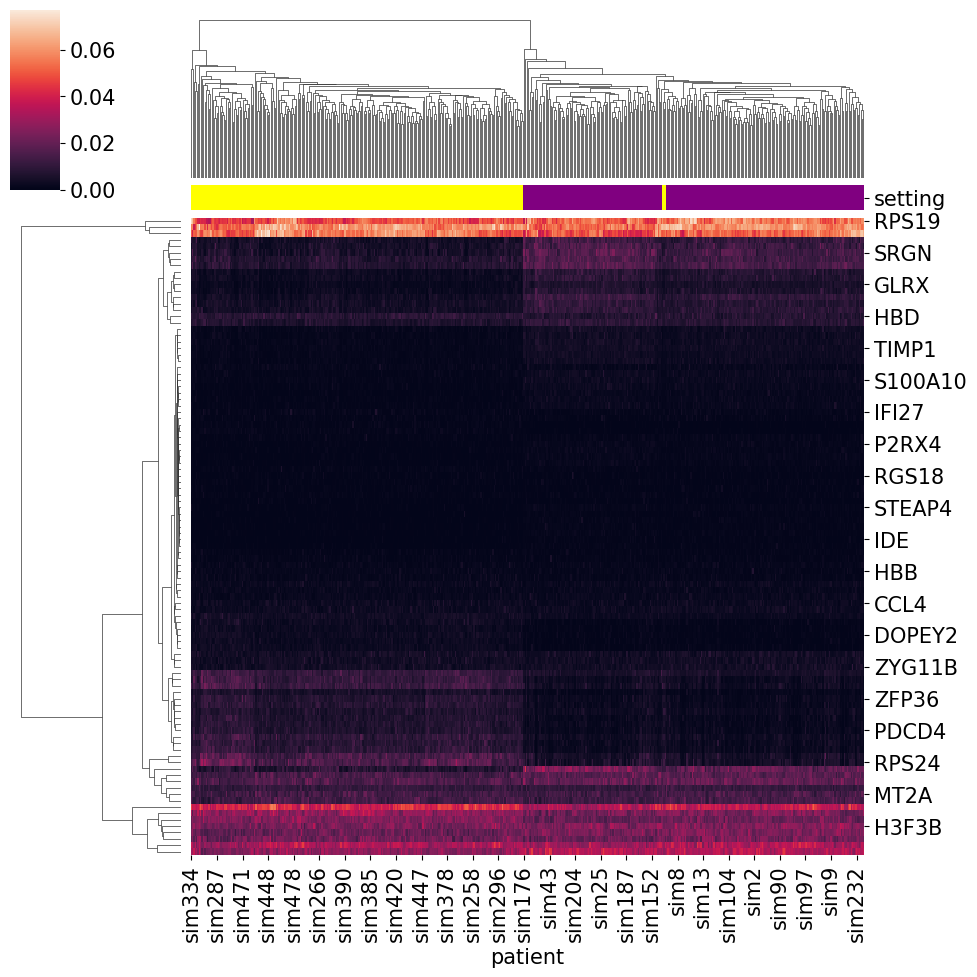

In [49]:
sns.clustermap(pseudobulk_lognorm.loc[topvargenes,:], col_colors=gt_adata.obs[['patient','setting']].drop_duplicates().set_index('patient').setting.cat.rename_categories({'Bcellfrac0.065':'purple', 'Bcellfrac0.25':'yellow'}))

# Viz Patient Reps

In [14]:
# Sillhouette score and ARI index

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
                 
patient_cats = recon_adata.obs[['patient','setting']].drop_duplicates().setting
for layer in np.arange(len(summary['enc_hiddens'][0])):
    print("layer {}".format(layer))
    val_hiddens = torch.concat([batch[layer] for batch in summary['enc_hiddens']]) #final hidden rep in encoder for each patient in the val set
    val_hiddens = val_hiddens.reshape(val_hiddens.shape[0], -1)
    sil = silhouette_score(val_hiddens, patient_cats)
    print("sillhouette score: {}".format(round(sil,2)))
    
    clusters = KMeans(n_clusters=2).fit_predict(val_hiddens)
    ari = adjusted_rand_score(patient_cats, clusters)
    print("ARI: {}".format(round(ari,2)))
    print("\n")


layer 0
sillhouette score: 0.3199999928474426
ARI: 0.57


layer 1
sillhouette score: 0.5600000023841858
ARI: 0.84


layer 2
sillhouette score: 0.5799999833106995
ARI: 0.84


layer 3
sillhouette score: 0.6700000166893005
ARI: 0.84


layer 4
sillhouette score: 0.800000011920929
ARI: 0.96




### val set

### viz all levels of encoder

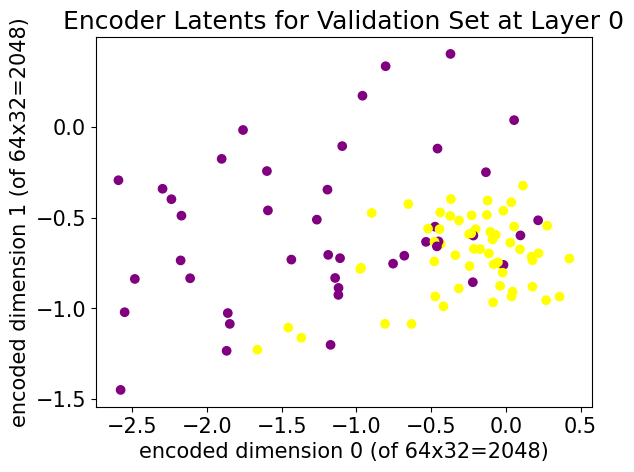

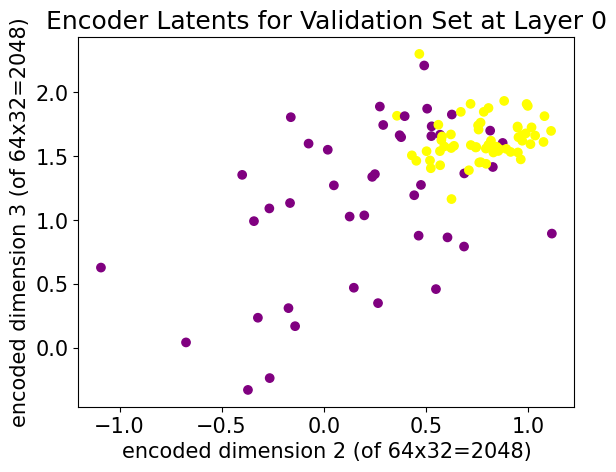

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


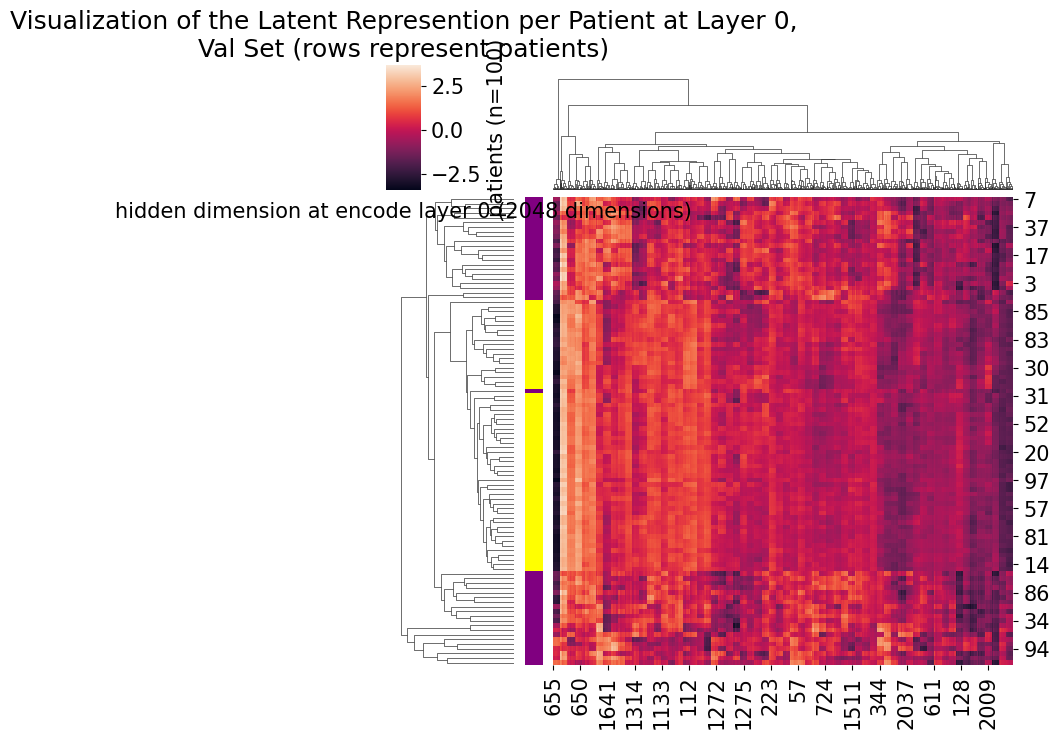

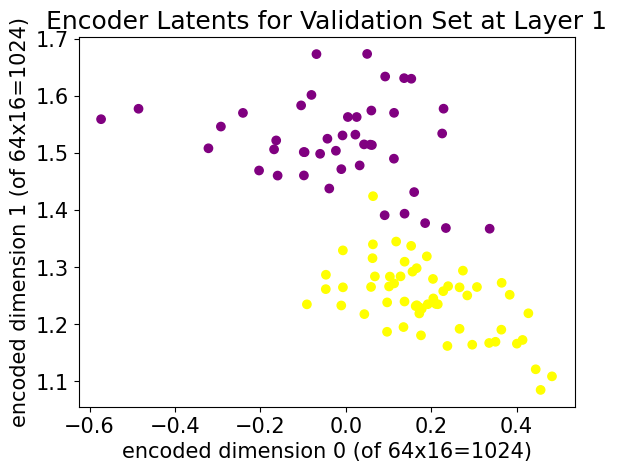

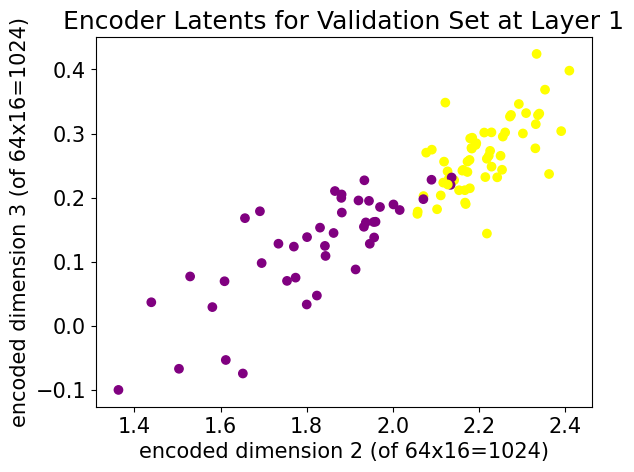

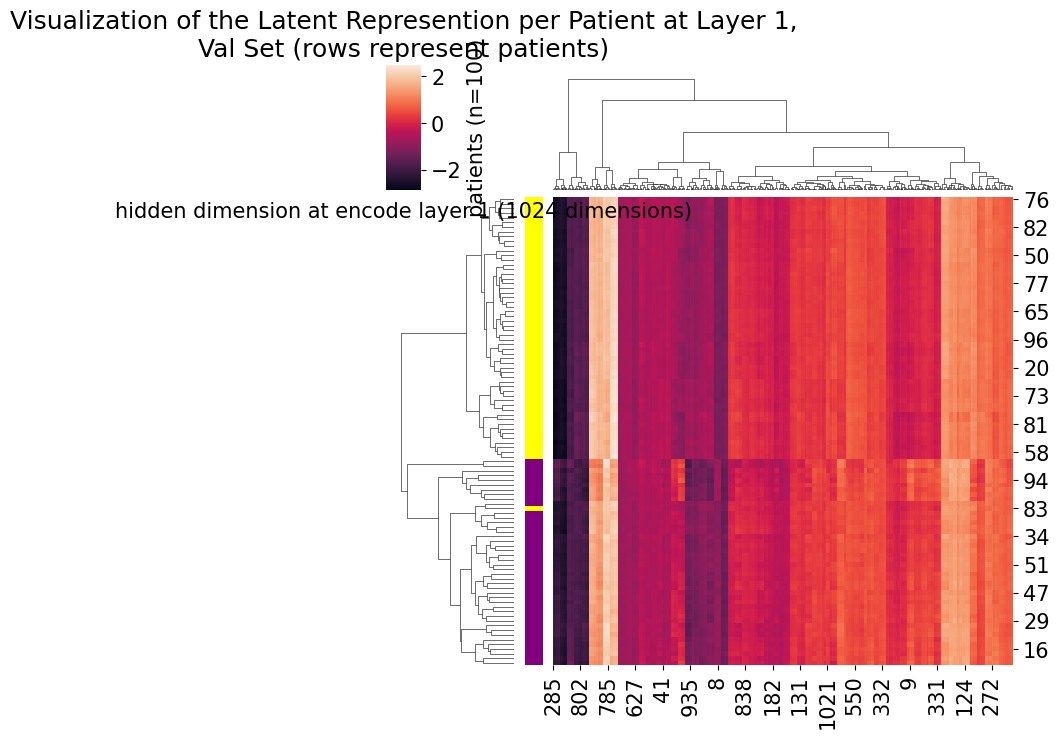

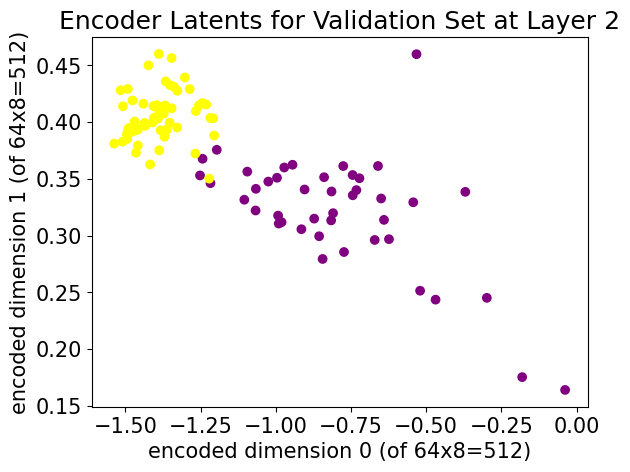

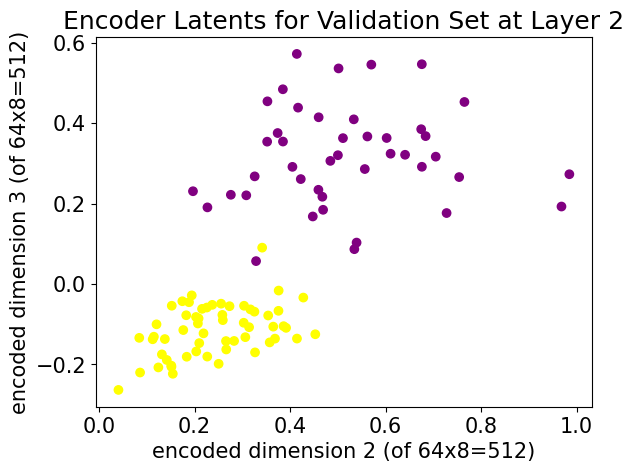

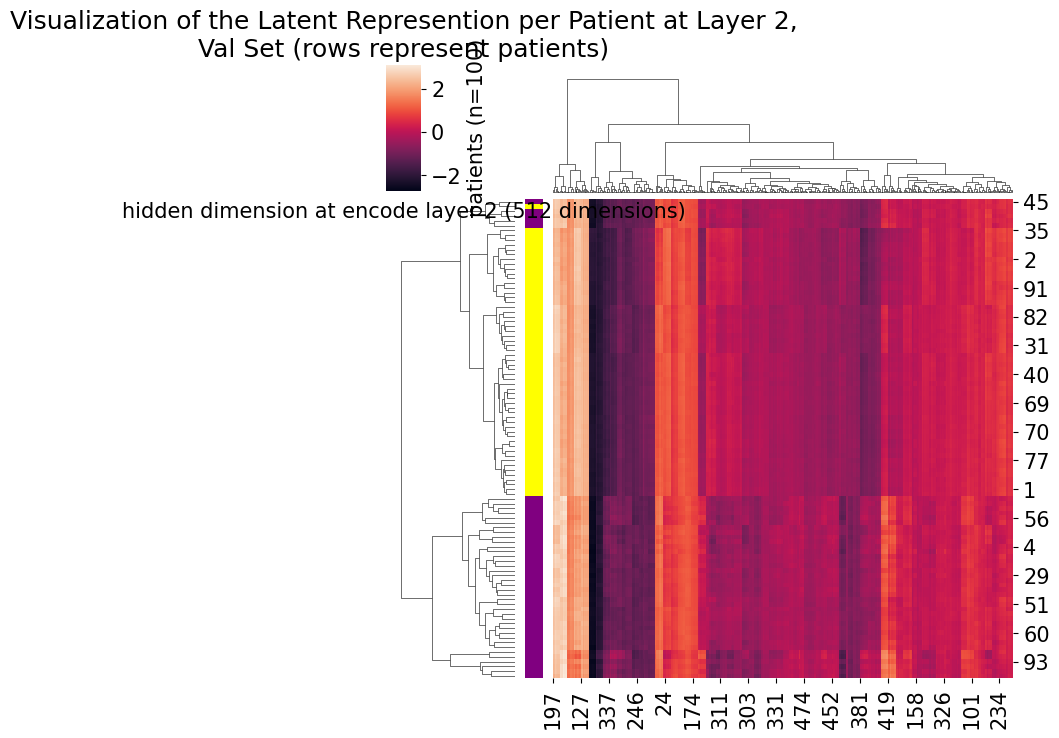

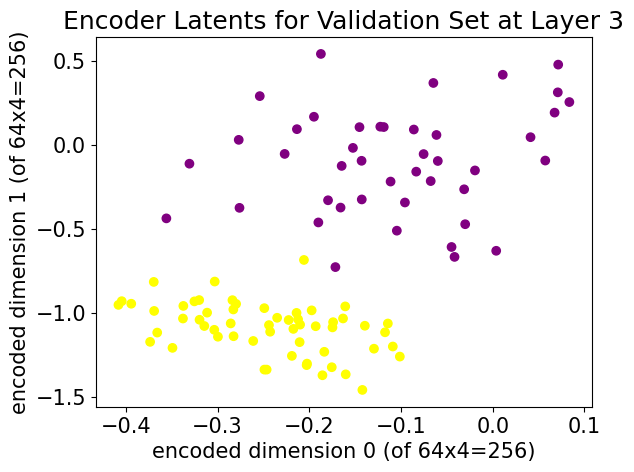

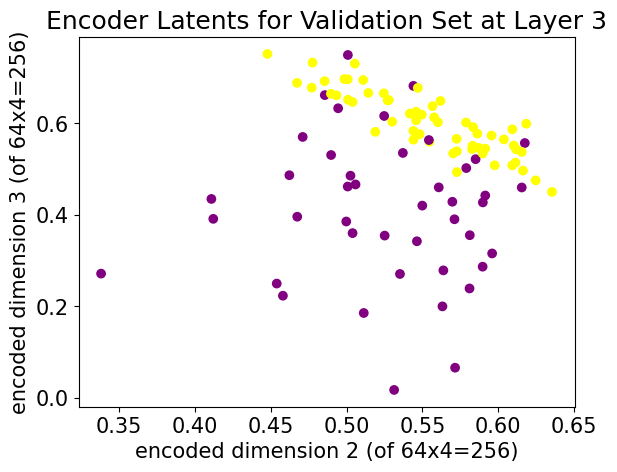

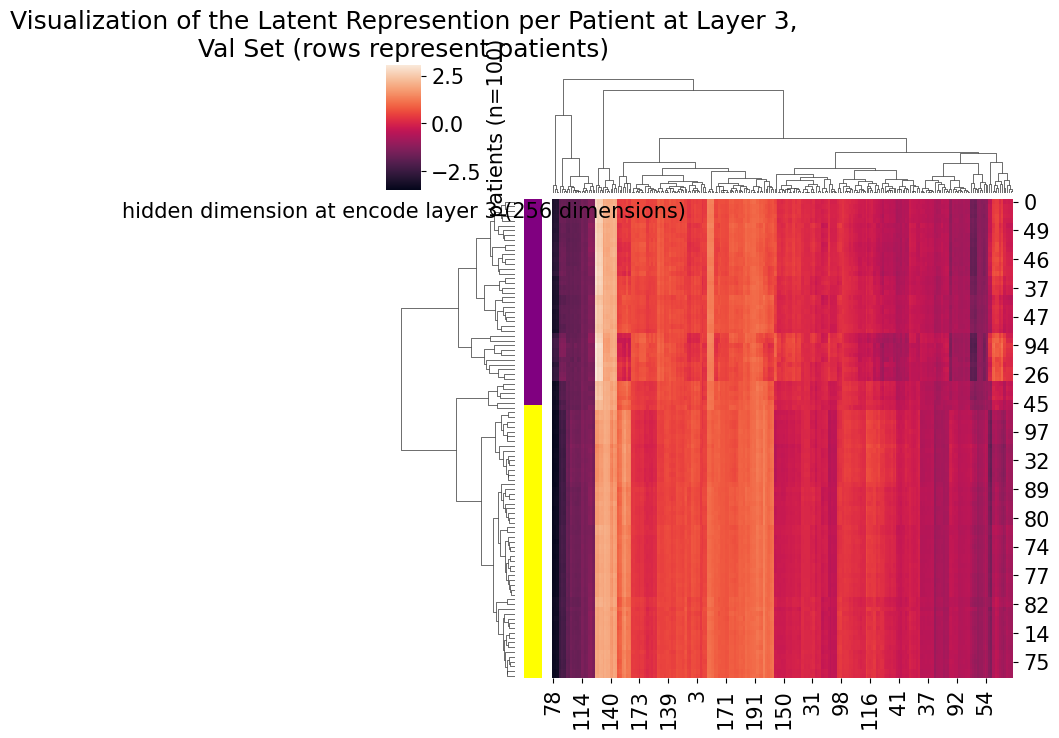

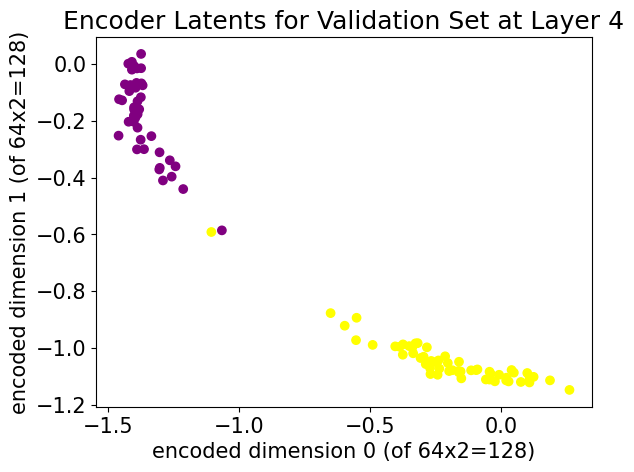

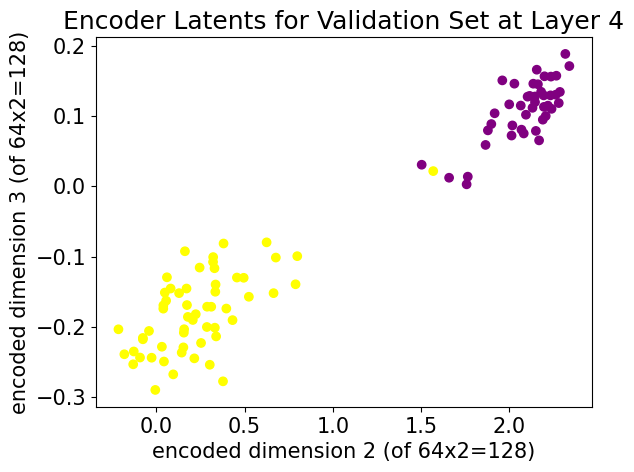

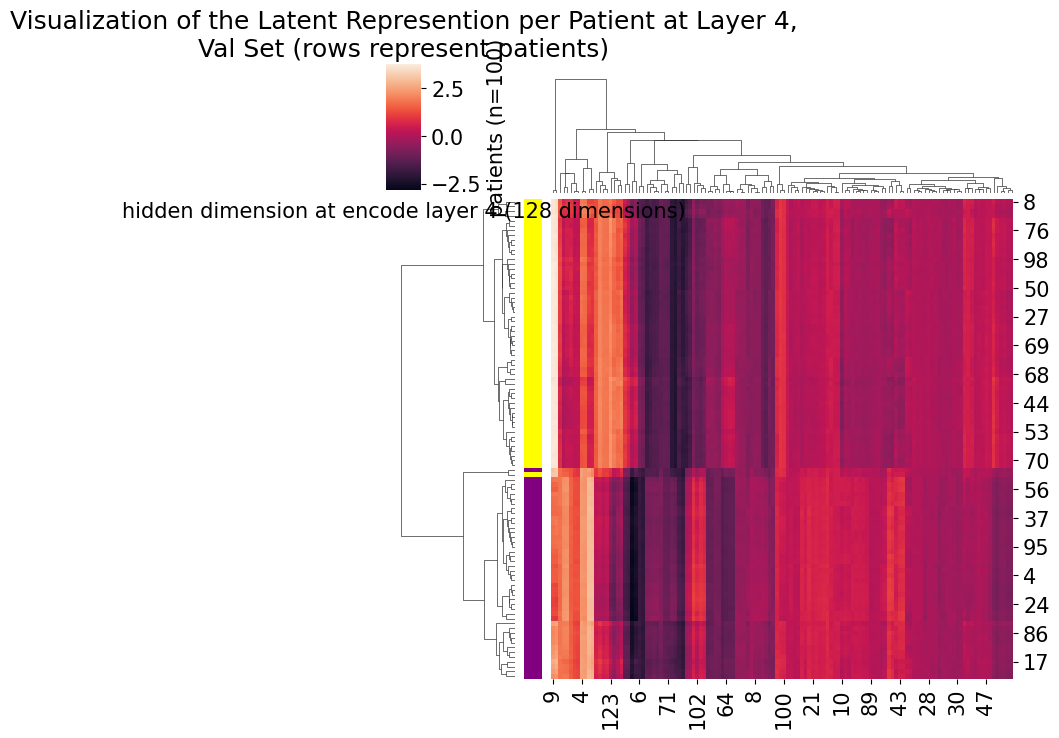

In [77]:
patient_cats = recon_adata.obs[['patient','setting']].drop_duplicates().setting.cat.rename_categories({'Bcellfrac0.065':'purple', 'Bcellfrac0.25':'yellow'})
for layer in np.arange(len(summary['enc_hiddens'][0])):
    val_hiddens = torch.concat([batch[layer] for batch in summary['enc_hiddens']]) #final hidden rep in encoder for each patient in the val set
    val_hiddens = val_hiddens.reshape(val_hiddens.shape[0], -1)

    plt.scatter(val_hiddens[:,0],val_hiddens[:,1], c=patient_cats)
    plt.title("Encoder Latents for Validation Set at Layer {}".format(layer))
    plt.xlabel("encoded dimension 0 (of 64x{}={})".format(summary['enc_hiddens'][0][layer].shape[1], summary['enc_hiddens'][0][layer].shape[1]*64))
    plt.ylabel("encoded dimension 1 (of 64x{}={})".format(summary['enc_hiddens'][0][layer].shape[1], summary['enc_hiddens'][0][layer].shape[1]*64))
    plt.show()
    
    plt.scatter(val_hiddens[:,2],val_hiddens[:,3], c=patient_cats)
    plt.title("Encoder Latents for Validation Set at Layer {}".format(layer))
    plt.xlabel("encoded dimension 2 (of 64x{}={})".format(summary['enc_hiddens'][0][layer].shape[1], summary['enc_hiddens'][0][layer].shape[1]*64))
    plt.ylabel("encoded dimension 3 (of 64x{}={})".format(summary['enc_hiddens'][0][layer].shape[1], summary['enc_hiddens'][0][layer].shape[1]*64))
    plt.show()
    
    # visualize the dataset in heatmap
    sns.clustermap(val_hiddens, figsize=(7,7), row_colors=patient_cats.to_numpy())
    plt.title("Visualization of the Latent Represention per Patient at Layer {},\nVal Set (rows represent patients)".format(layer))
    plt.ylabel("patients (n={})".format(len(val_hiddens)))
    plt.xlabel("hidden dimension at encode layer {} ({} dimensions)".format(layer, val_hiddens.shape[1]))
    plt.show()
    
    if False:
        # z score each latent dimension across patients
        scaled_hiddens = (val_hiddens - val_hiddens.mean(axis=0)) / val_hiddens.std(axis=0)
        sns.clustermap(scaled_hiddens, figsize=(7,7))
        plt.title("Visualization of the Z-Scored Latent Represention per Patient at Layer {},\nVal Set (rows represent patients)".format(layer))
        plt.ylabel("patients (n={})".format(len(scaled_hiddens)))
        plt.xlabel("hidden dimension at encode layer {} ({} dimensions)".format(layer, val_hiddens.shape[1]))
        plt.show()

# PCA for 10 val set patients

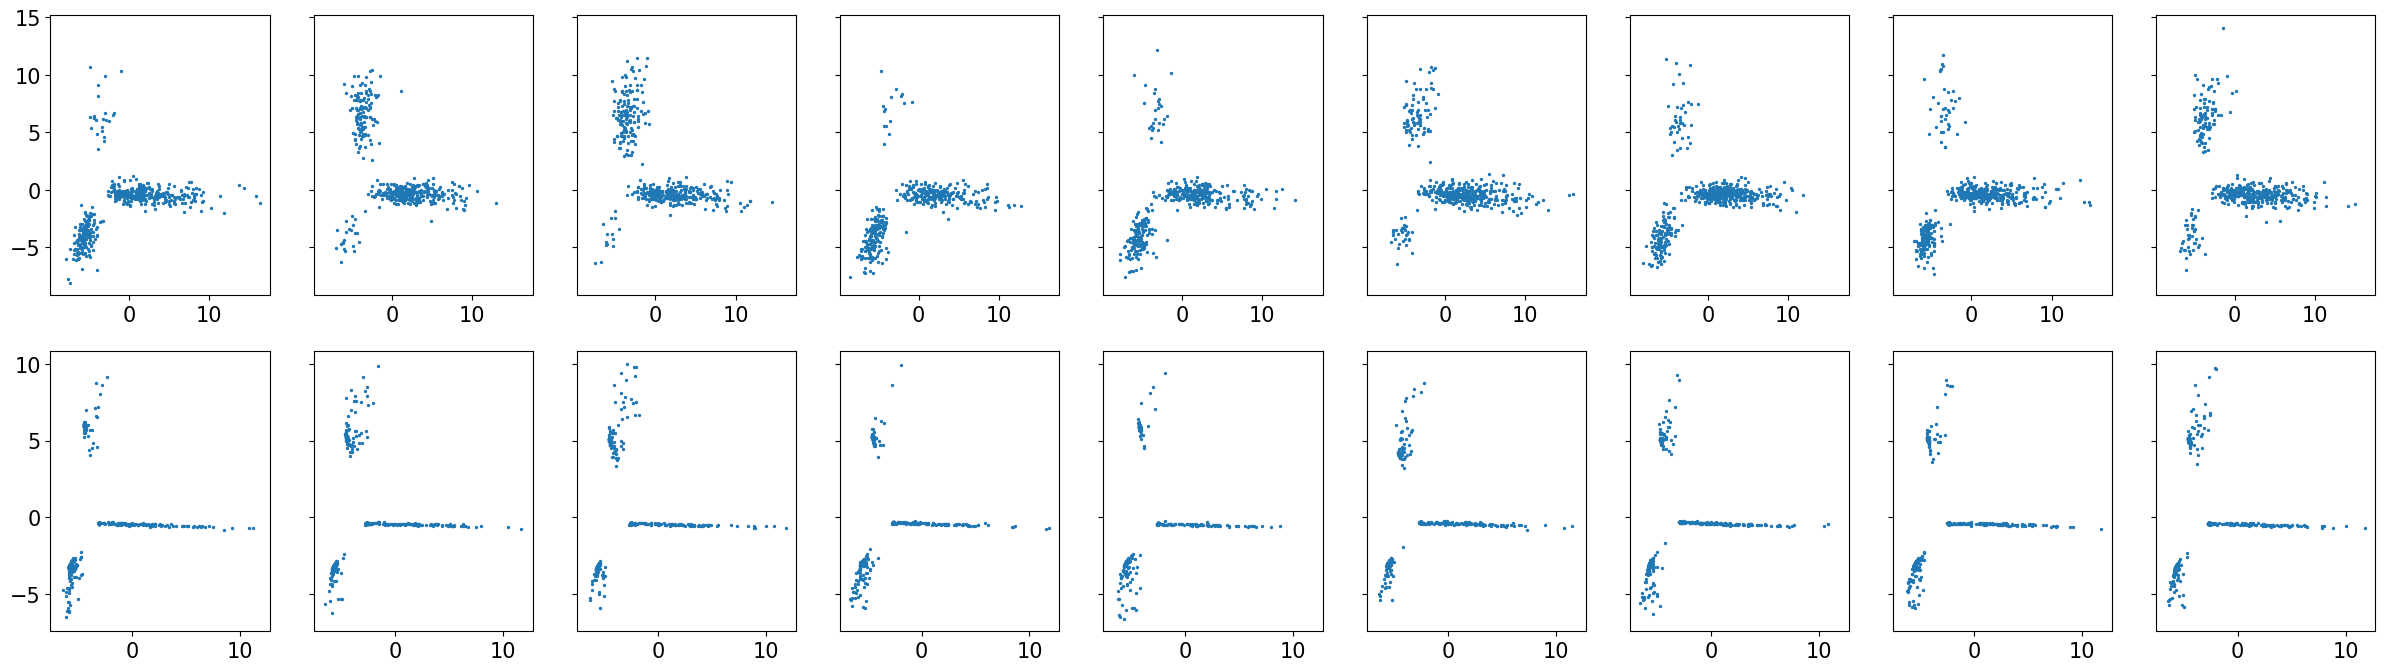

In [64]:
fig, axs = plt.subplots(2,9, figsize=(30,8), sharex="row", sharey="row",)# gridspec_kw={'hspace':0.3})
for idx, pid in enumerate(recon_adata.obs.patient.drop_duplicates()[:9]):
    axs[0, idx].scatter(gt_adata[gt_adata.obs.patient == pid].obsm['X_pca'][:,0], gt_adata[gt_adata.obs.patient == pid].obsm['X_pca'][:,1], s=2)
    axs[1, idx].scatter(recon_adata[recon_adata.obs.patient==pid].obsm['X_pca'][:,0], recon_adata[recon_adata.obs.patient==pid].obsm['X_pca'][:,1], s=2)
plt.show()

# Visualize outputs of the decoder

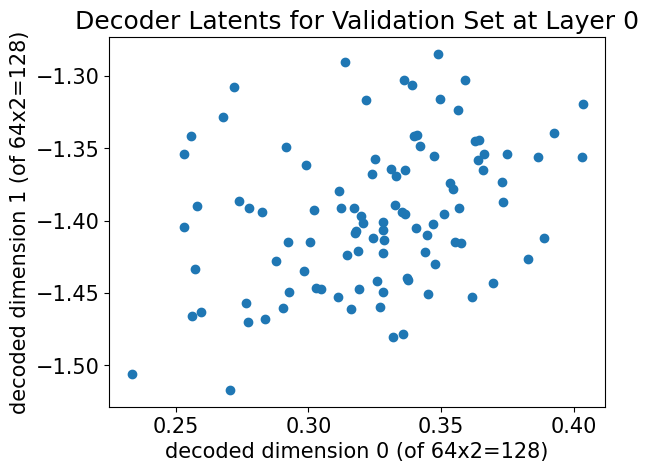

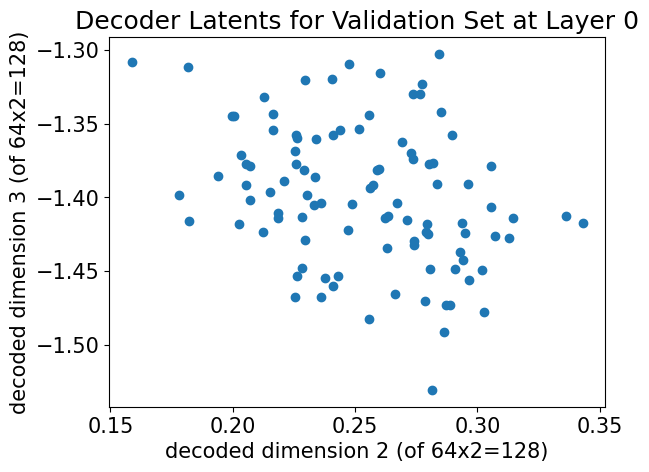

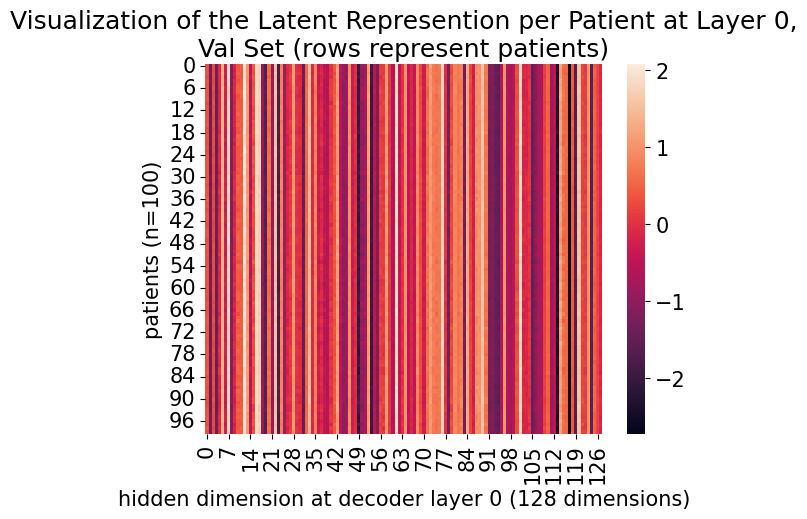

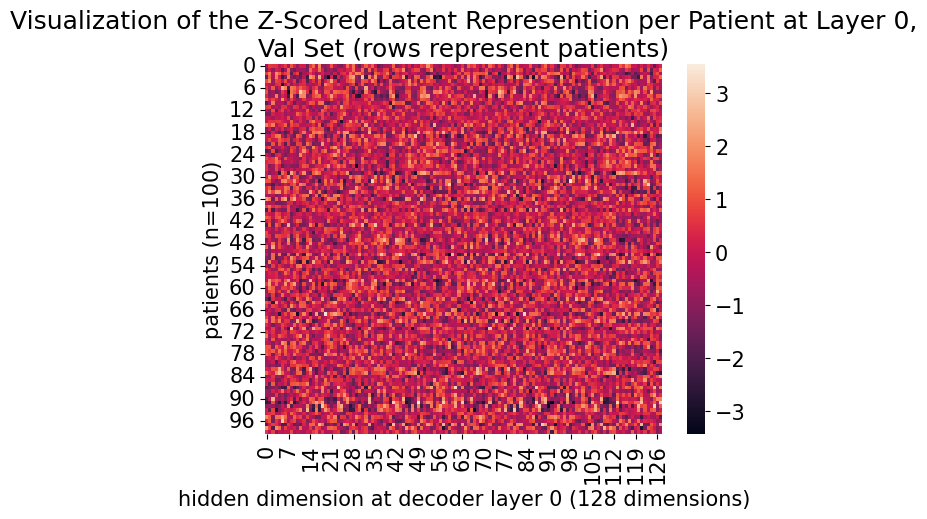

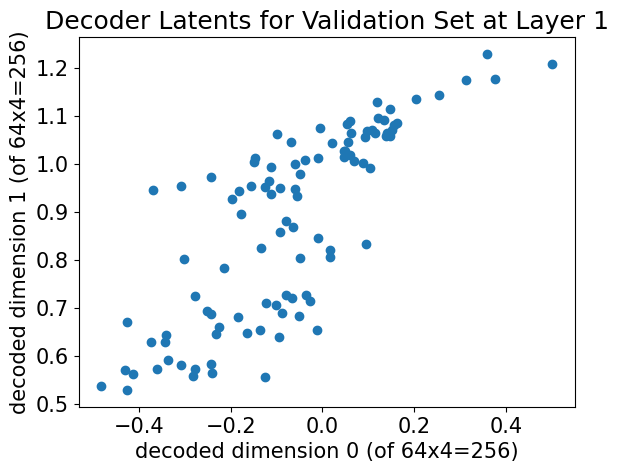

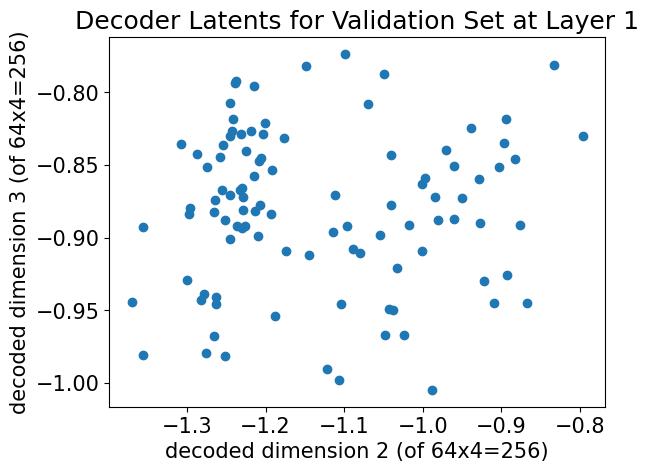

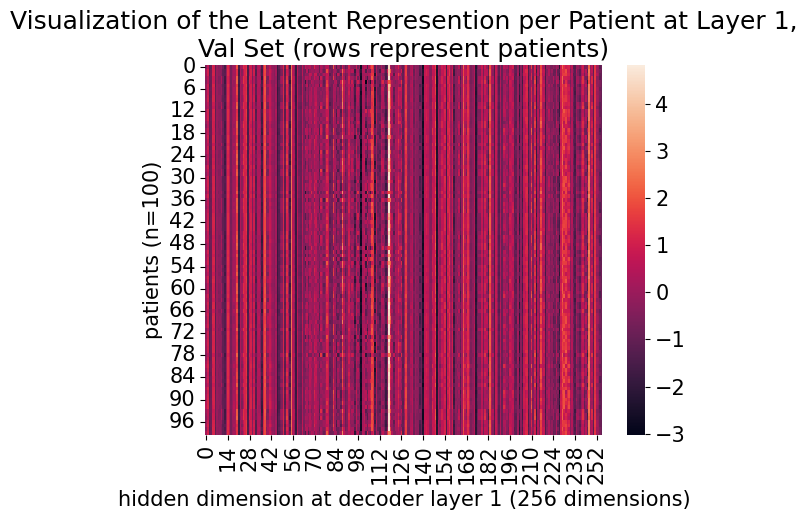

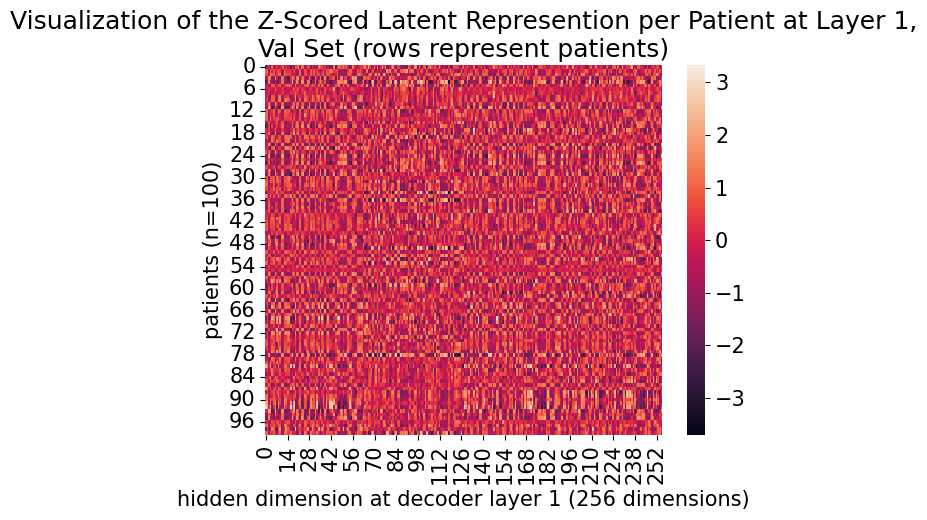

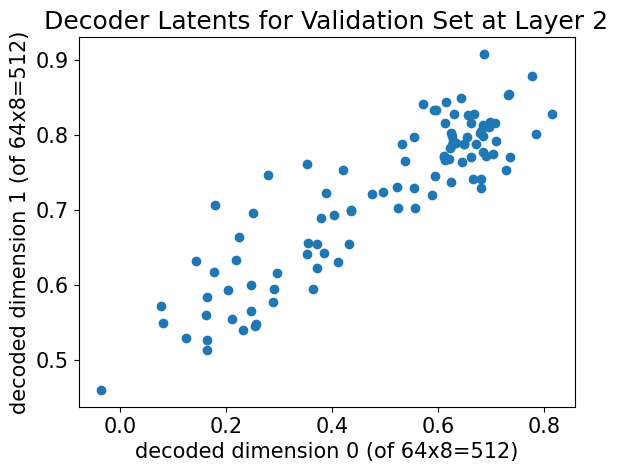

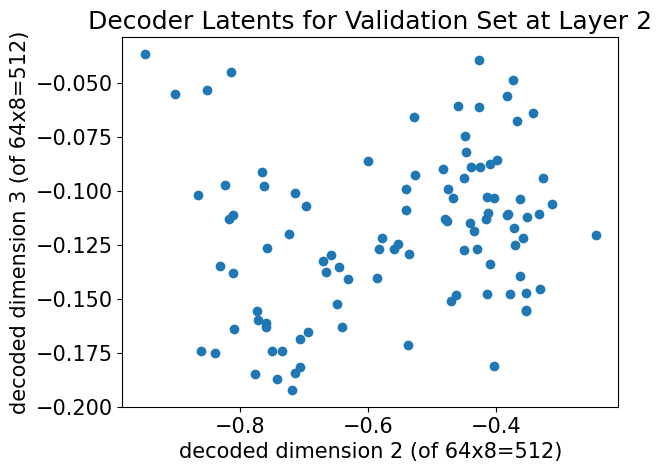

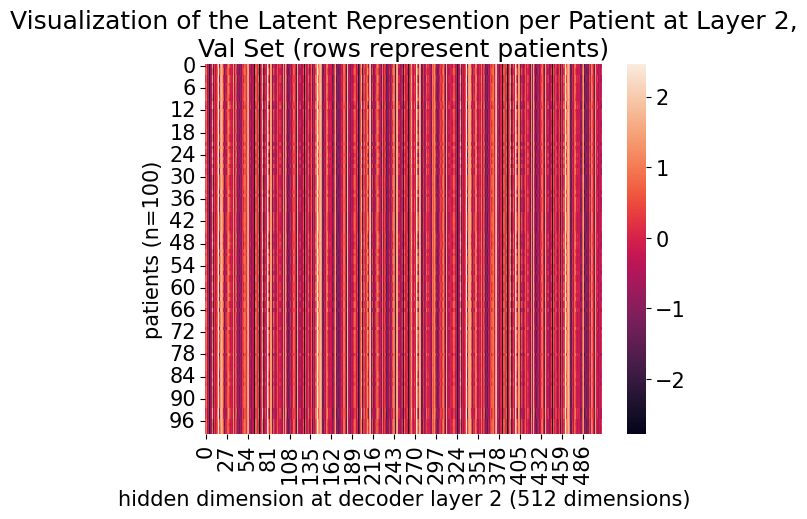

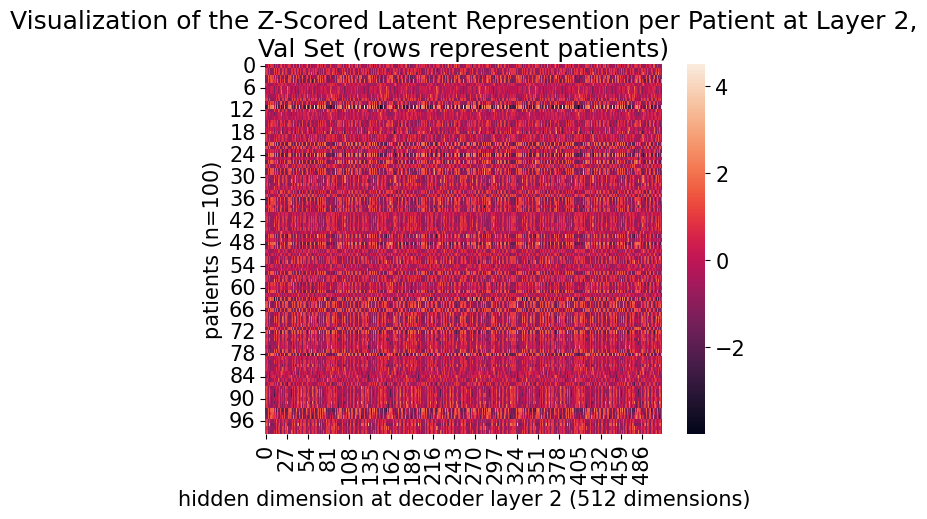

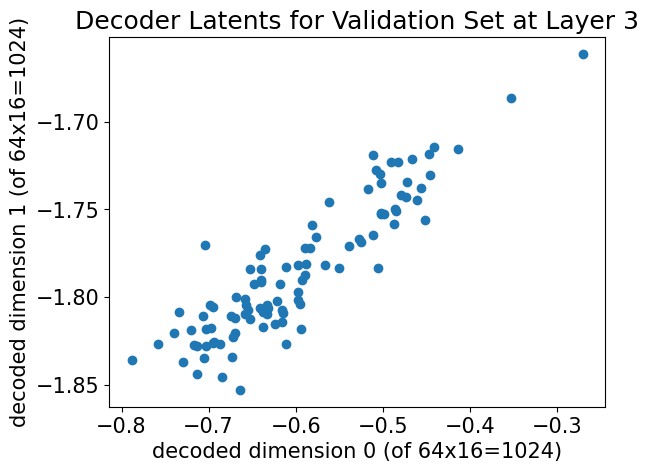

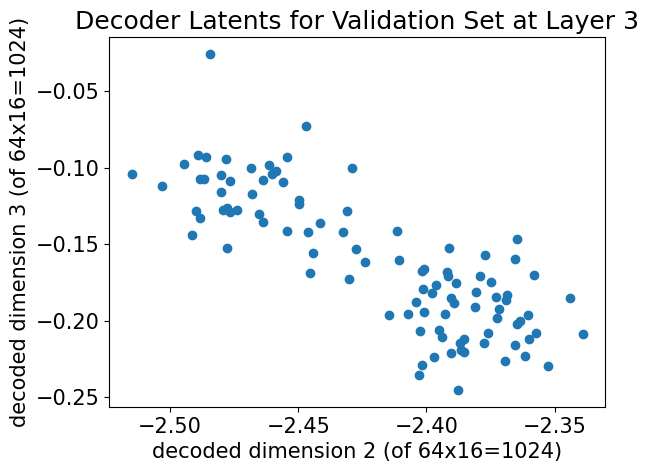

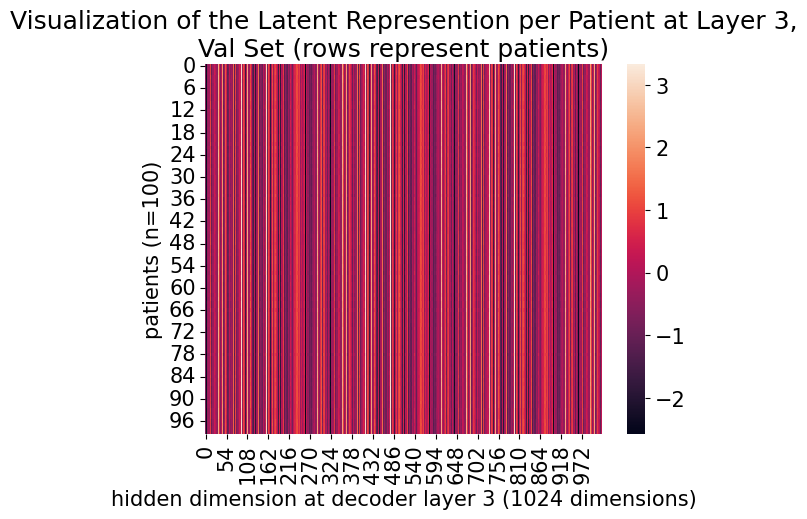

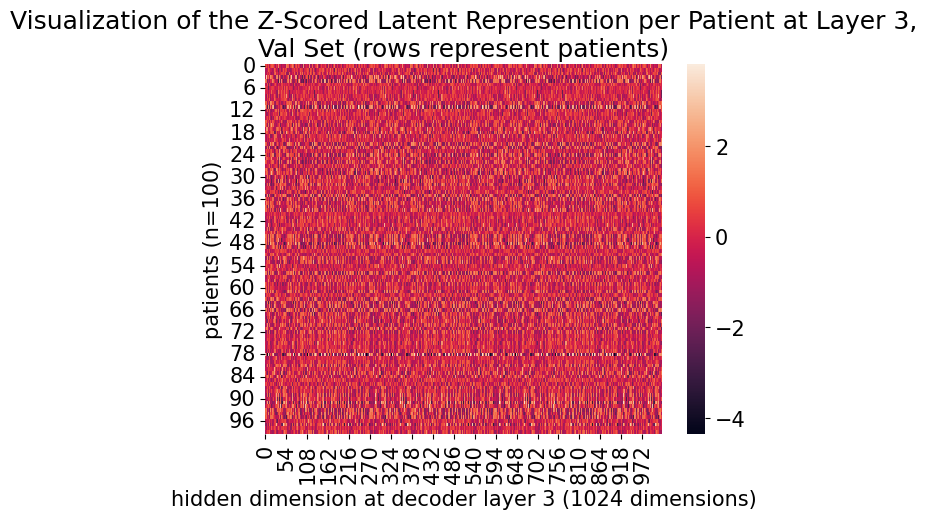

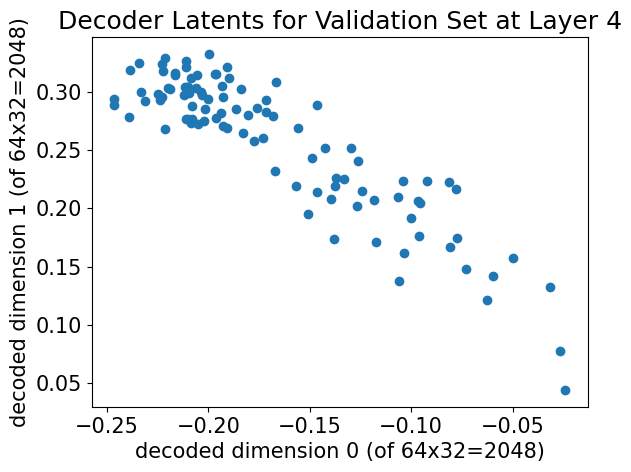

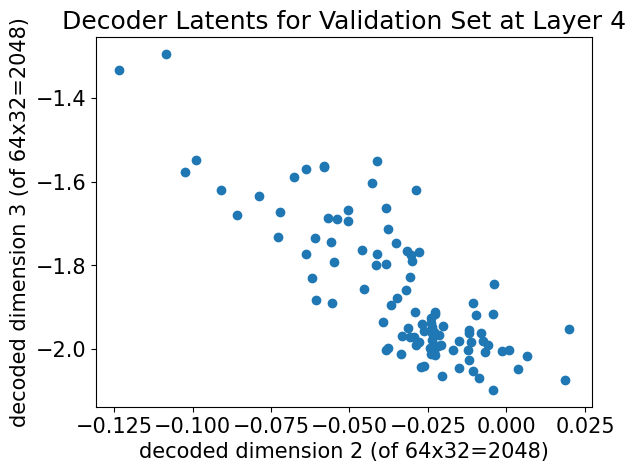

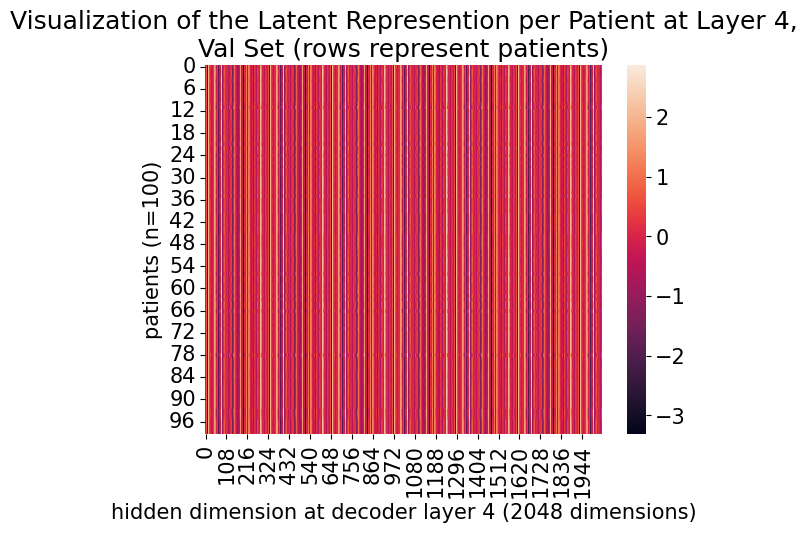

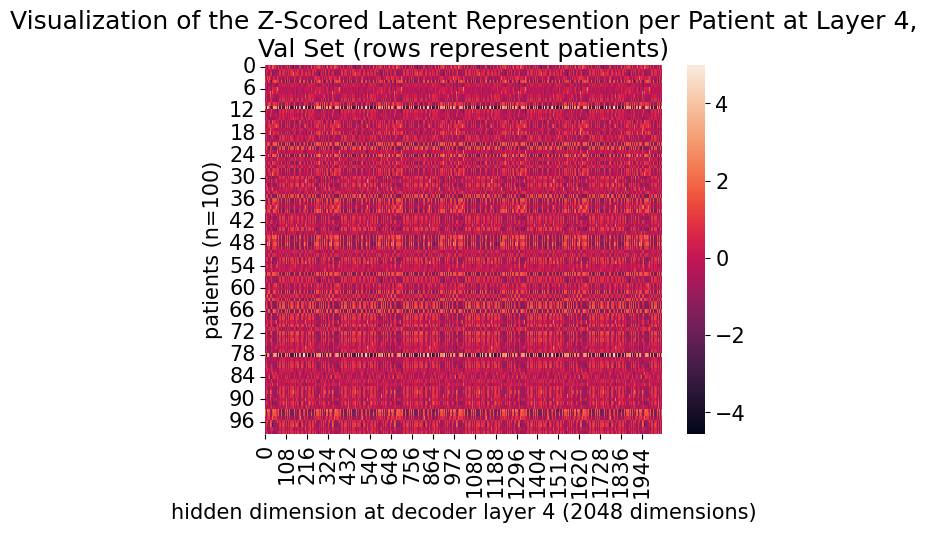

In [65]:
for layer in np.arange(len(summary['dec_hiddens'][0])):
    val_hiddens = torch.concat([batch[layer] for batch in summary['dec_hiddens']]) #final hidden rep in encoder for each patient in the val set
    val_hiddens = val_hiddens.reshape(val_hiddens.shape[0], -1)

    plt.scatter(val_hiddens[:,0],val_hiddens[:,1])
    plt.title("Decoder Latents for Validation Set at Layer {}".format(layer))
    plt.xlabel("decoded dimension 0 (of {}x{}={})".format(summary['dec_hiddens'][0][layer].shape[2], summary['dec_hiddens'][0][layer].shape[1], summary['dec_hiddens'][0][layer].shape[1]*summary['dec_hiddens'][0][layer].shape[2]))
    plt.ylabel("decoded dimension 1 (of {}x{}={})".format(summary['dec_hiddens'][0][layer].shape[2], summary['dec_hiddens'][0][layer].shape[1], summary['dec_hiddens'][0][layer].shape[1]*summary['dec_hiddens'][0][layer].shape[2]))
    plt.show()
    
    plt.scatter(val_hiddens[:,2],val_hiddens[:,3])
    plt.title("Decoder Latents for Validation Set at Layer {}".format(layer))
    plt.xlabel("decoded dimension 2 (of {}x{}={})".format(summary['dec_hiddens'][0][layer].shape[2], summary['dec_hiddens'][0][layer].shape[1], summary['dec_hiddens'][0][layer].shape[1]*summary['dec_hiddens'][0][layer].shape[2]))
    plt.ylabel("decoded dimension 3 (of {}x{}={})".format(summary['dec_hiddens'][0][layer].shape[2], summary['dec_hiddens'][0][layer].shape[1], summary['dec_hiddens'][0][layer].shape[1]*summary['dec_hiddens'][0][layer].shape[2]))
    plt.show()
    
    # visualize the dataset in heatmap
    sns.heatmap(val_hiddens)
    plt.title("Visualization of the Latent Represention per Patient at Layer {},\nVal Set (rows represent patients)".format(layer))
    plt.ylabel("patients (n={})".format(len(val_hiddens)))
    plt.xlabel("hidden dimension at decoder layer {} ({} dimensions)".format(layer, val_hiddens.shape[1]))
    plt.show()
    
    # z score each latent dimension across patients
    scaled_hiddens = (val_hiddens - val_hiddens.mean(axis=0)) / val_hiddens.std(axis=0)
    sns.heatmap(scaled_hiddens)
    plt.title("Visualization of the Z-Scored Latent Represention per Patient at Layer {},\nVal Set (rows represent patients)".format(layer))
    plt.ylabel("patients (n={})".format(len(scaled_hiddens)))
    plt.xlabel("hidden dimension at decoder layer {} ({} dimensions)".format(layer, val_hiddens.shape[1]))
    plt.show()

# do reconstructed training images have same issue 

In [31]:
summary_train_name = os.path.join('/home/rpeyser/GitHub/scSet/gen/', experiment_name, 'checkpoints/', experiment_name, 'summary_train_recon.pth')

summary_train = torch.load(summary_train_name)
for k, v in summary_train.items():
    try:
        print(f"{k}: {v.shape}")
    except AttributeError:
        print(f"{k}: {len(v)}")

recon_set: torch.Size([400, 700, 20])
recon_mask: torch.Size([400, 700])
posteriors: 6
dec_att: 5
enc_att: 5
enc_hiddens: 50
init_set: torch.Size([400, 700, 64])
dec_hiddens: 50
dec_latents: 50
gt_set: torch.Size([400, 504, 20])
gt_mask: torch.Size([400, 504])
mean: torch.Size([50])
std: torch.Size([50])
sid: 50
mid: 50
pid: 50
cardinality: 50


In [32]:
len_att = len(summary_train['dec_att'])
gt_train = summary_train['gt_set']
gt_mask_train = summary_train['gt_mask']

recon_train = summary_train['recon_set']
recon_mask_train = summary_train['recon_mask']

dec_att_train = [summary_train['dec_att'][l] for l in range(len_att)]
enc_att_train = [summary_train['enc_att'][l] for l in range(len_att)]

In [33]:
recon_train_adata = sc.AnnData(np.zeros([recon_train.reshape(-1,20)[(~recon_mask_train).reshape(-1),:].shape[0], len(gt_adata.var)])) #only take unmasked outputs!!!

/tmp/ipykernel_4063591/3603225547.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  recon_train_adata = sc.AnnData(np.zeros([recon_train.reshape(-1,20)[(~recon_mask_train).reshape(-1),:].shape[0], len(gt_adata.var)])) #only take unmasked outputs!!!


In [34]:
recon_train_adata.varm['PCs'] = gt_adata.varm['PCs']

In [35]:
recon_train_adata.obsm['X_pca'] = recon_train.reshape(-1,20)[(~recon_mask_train).reshape(-1),:].numpy() #only take unmasked outputs!!

In [36]:
recon_train_adata.var = gt_adata.var[['highly_variable','means','dispersions','mean','std']].rename(columns={'highly_variable':'highly_variable_orig', 'means':'means_orig', 'dispersions':'dispersions_orig', 'mean':'mean_orig', 'std':'std_orig'})



In [38]:
## add info to recon_adata.obs

#add patient is
recon_train_pids = list(itertools.chain.from_iterable(summary_train['pid']))
recon_train_adata.obs['patient'] = np.repeat(recon_train_pids, (~recon_mask_train).sum(axis=1))

#add patients groups 
recon_train_adata.obs = recon_train_adata.obs.merge(gt_adata.obs[['patient', 'setting']].drop_duplicates(), on="patient", how="left")

recon_train_adata.obs.index = recon_train_adata.obs.patient

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


#### calculate neighbors & UMAP for reconstructed cells (train set)

In [39]:
sc.pp.neighbors(recon_train_adata, n_neighbors=30, n_pcs=20)

In [ ]:
sc.tl.umap(recon_train_adata)

In [ ]:
sc.pl.umap(recon_train_adata, color='group')

In [ ]:
#add PCs to obs in order to color by them
recon_train_adata.obs = pd.concat([recon_train_adata.obs, pd.DataFrame(recon_train_adata.obsm['X_pca'], 
                                                                                  index=recon_train_adata.obs.index, 
                                                                                  columns=["PC"+str(i) for i in range(1,recon_train_adata.obsm['X_pca'].shape[1]+1)])], axis=1)



In [ ]:
sc.pl.umap(recon_train_adata, color=["PC"+str(i) for i in range(1,11)])

In [ ]:
plt.scatter(recon_adata.obsm['X_pca'] [:,0], recon_adata.obsm['X_pca'][:,1], s=2)
plt.title("Reconstructed PC1 and PC2 Values (Validation Set)")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")

In [ ]:
plt.scatter(gt_adata.obsm['X_pca'] [:,0], gt_adata.obsm['X_pca'][:,1], s=2)
plt.title("Ground Truth PC1 and PC2 Values")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
